In [20]:
import matplotlib.pyplot as plt
import numpy as np
import imutils
import cv2

from imutils import paths
from tensorflow import keras
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


from tqdm import tqdm

In [21]:
class BatchGenerator(Sequence):
    def __init__(self, path_approve, path_reprove, batch_size, image_size=(28, 28), gray_scale=True):
        self._batch_size = batch_size
        images_reprove = list(paths.list_images(path_reprove))[:300]  # para fins de exemplo vamos utilziar apenas 300 imagens
        images_approve = list(paths.list_images(path_reprove))[:200]
        self._images_path = images_approve.__add__(images_reprove)
        self._image_size = image_size
        self._gray_scale = gray_scale

    def __len__(self):
        return int(np.ceil(len(self._images_path) / self._batch_size))

    def __getitem__(self, idx):
        l_bound = idx * self._batch_size
        r_bound = (idx + 1) * self._batch_size

        if r_bound > len(self._images_path):
            r_bound = len(self._images_path)
            l_bound = r_bound - self._batch_size

        instance_count = 0
        x_batch = np.zeros((r_bound - l_bound, self._image_size[1], self._image_size[0], 1 if self._gray_scale else 3))

        for instance_count, train_instance in enumerate(self._images_path[l_bound:r_bound]):
            image = cv2.imread(train_instance)
            image = cv2.resize(image, self._image_size)
            if self._gray_scale:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = image[..., np.newaxis]
            image = image / 255
            x_batch[instance_count] = image

        return x_batch, x_batch

    def on_epoch_end(self):
        np.random.shuffle(self._images_path)

In [22]:
train_generator = BatchGenerator("data\GM-Closed\GM-Closed-Approve", "data\GM-Closed\GM-Closed-Reprove",  8)
val_generator = BatchGenerator("data\GM-Closed\GM-Closed-Approve", "data\GM-Closed\GM-Closed-Reprove",  8)

In [23]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # output (4, 4, 8)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [24]:
MODEL_NAME="nome"
best_loss_model_name=f"{MODEL_NAME}_best_loss.h5"
check_point_saver_best_loss = ModelCheckpoint(best_loss_model_name, monitor="val_loss",verbose=1,
                                              save_best_only=True, save_weights_only=False, mode ="auto", period=1)

In [25]:
autoencoder.fit(train_generator, validation_data=val_generator,epochs=200,callbacks=[check_point_saver_best_loss])

Epoch 1/200
63/63 [==============================] - ETA: 0s - loss: 0.5733
Epoch 1: val_loss improved from inf to 0.51604, saving model to nome_best_loss.h5
63/63 [==============================] - 9s 127ms/step - loss: 0.5733 - val_loss: 0.5160
Epoch 2/200
63/63 [==============================] - ETA: 0s - loss: 0.5092
Epoch 2: val_loss improved from 0.51604 to 0.50499, saving model to nome_best_loss.h5
63/63 [==============================] - 8s 122ms/step - loss: 0.5092 - val_loss: 0.5050
Epoch 3/200
63/63 [==============================] - ETA: 0s - loss: 0.5042
Epoch 3: val_loss improved from 0.50499 to 0.50092, saving model to nome_best_loss.h5
63/63 [==============================] - 8s 121ms/step - loss: 0.5042 - val_loss: 0.5009
Epoch 4/200
63/63 [==============================] - ETA: 0s - loss: 0.4980
Epoch 4: val_loss improved from 0.50092 to 0.49503, saving model to nome_best_loss.h5
63/63 [==============================] - 9s 144ms/step - loss: 0.4980 - val_loss: 0.4950


In [28]:
autoencoder = load_model(best_loss_model_name)


1/1 [==============================] - 0s 157ms/step


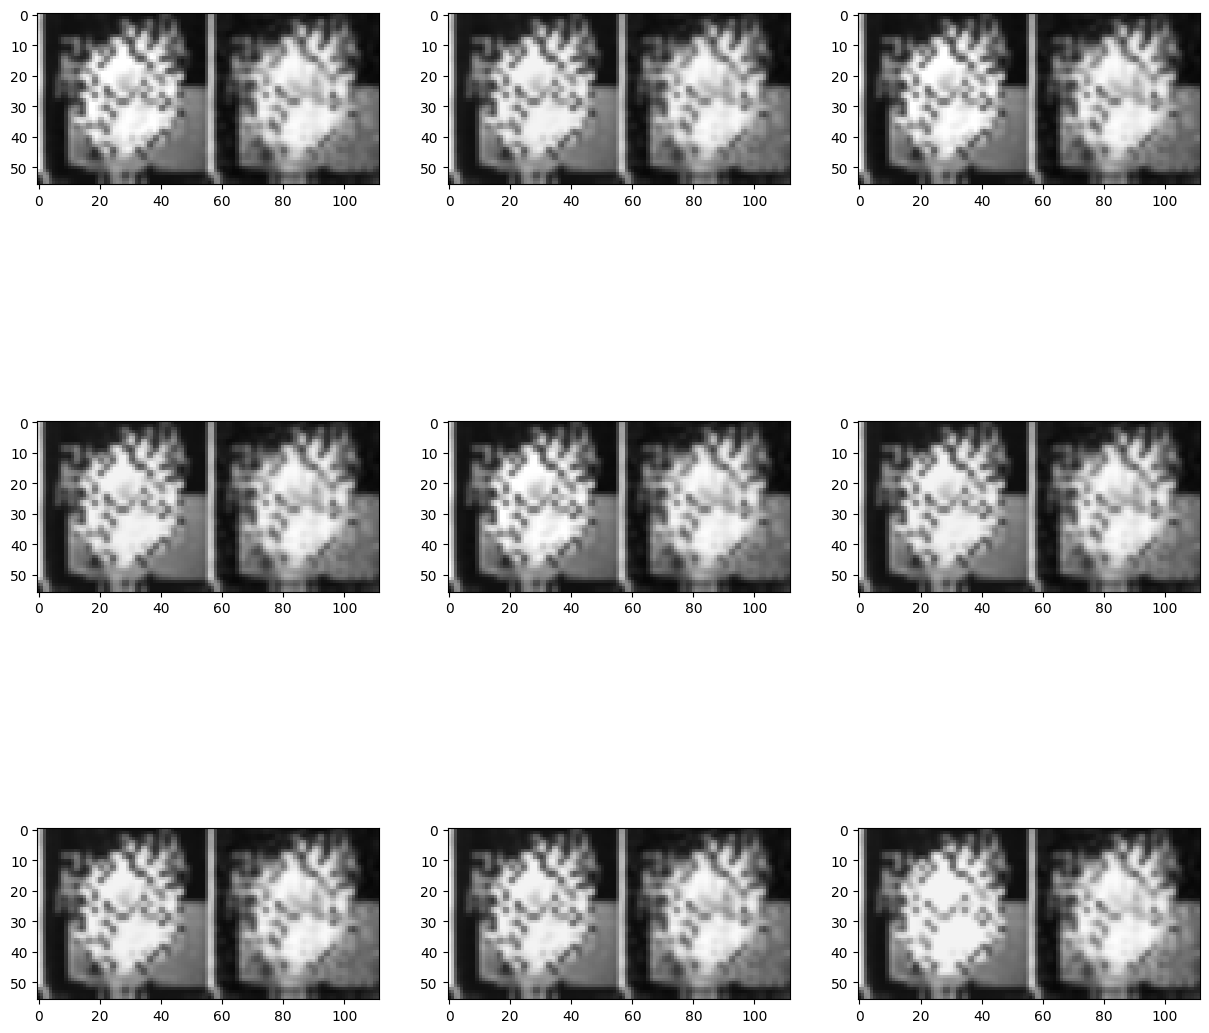

In [29]:
plt.figure(figsize=(15,15))

test_generator = BatchGenerator("data\GM-Closed\GM-Closed-Approve", "data\GM-Closed\GM-Closed-Reprove",  9)

batch = next(iter(test_generator))[0]

preds = autoencoder.predict(batch)
for i,(gt,pred) in enumerate(zip(batch,preds)):
    plt.subplot(3,3,i+1)

    gt = np.uint8(gt*255)
    pred = np.uint8(pred*255)
    concat= cv2.hconcat([gt,pred])
    concat = cv2.resize(concat, None, fx=2,fy=2)
    plt.imshow(cv2.cvtColor(concat, cv2.COLOR_GRAY2RGB))
plt.show()
